In [1]:
import joblib
import numpy as np

import mujoco
from hydrax.algs import CEM, MPPI, PredictiveSampling, Evosax
from hydrax.tasks.cart_pole import CartPole
from tasks.cart_pole_unconstrained import CartPoleUnconstrained
from tasks.pusht_unconstrained import PushTUnconstrained
from hydrax.tasks.cube import CubeRotation
from hydrax.tasks.pusht import PushT
from hydrax.tasks.humanoid_standup import HumanoidStandup
from hydrax.tasks.humanoid_mocap import HumanoidMocap
from hydrax.tasks.walker import Walker
from traj_opt_helper import traj_opt_helper
from algs import create_algorithm

/home/rooh/miniconda3/envs/hydrax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Parameters
num_trails = 6
max_iterations = 100
num_samples = 2048
sigma = 1.0
temperature = 0.1
spline = "zero"
horizon = 1.0
num_knots = 100 # set this to (horizon/mj_model.opt.time_step) will have no spline interpolation

# # CubeRotation
# task = CubeRotation()
# mj_model = task.mj_model
# mj_data = mujoco.MjData(mj_model)

# CartPole
task = CartPoleUnconstrained()
mj_model = task.mj_model
mj_data = mujoco.MjData(mj_model)


ctrl = create_algorithm(name = "CMA-ES", 
                        task = task,
                        num_samples = num_samples,
                        horizon = horizon,
                        num_knots = num_knots,
                        spline = spline,
                        temperature = temperature,
                        noise = sigma)

to = traj_opt_helper("CMA-ES", ctrl, mj_model, mj_data)

path = to.get_path()

CMAES_costs = joblib.load(path + "CMA-ES_costs_trails_average.pkl")
PS_costs = joblib.load(path + "PredictiveSampling_costs_trails_average.pkl")
MPPI_costs = joblib.load(path + "MPPI_costs_trails_average.pkl")
MPPI_CMA_costs = joblib.load(path + "MPPI-CMA_costs_trails_average.pkl")
GS_costs = joblib.load(path + "RandomizedSmoothing_costs_trails_average.pkl")

Trajectory Optimization with 100 steps over a 1.0 second horizon.


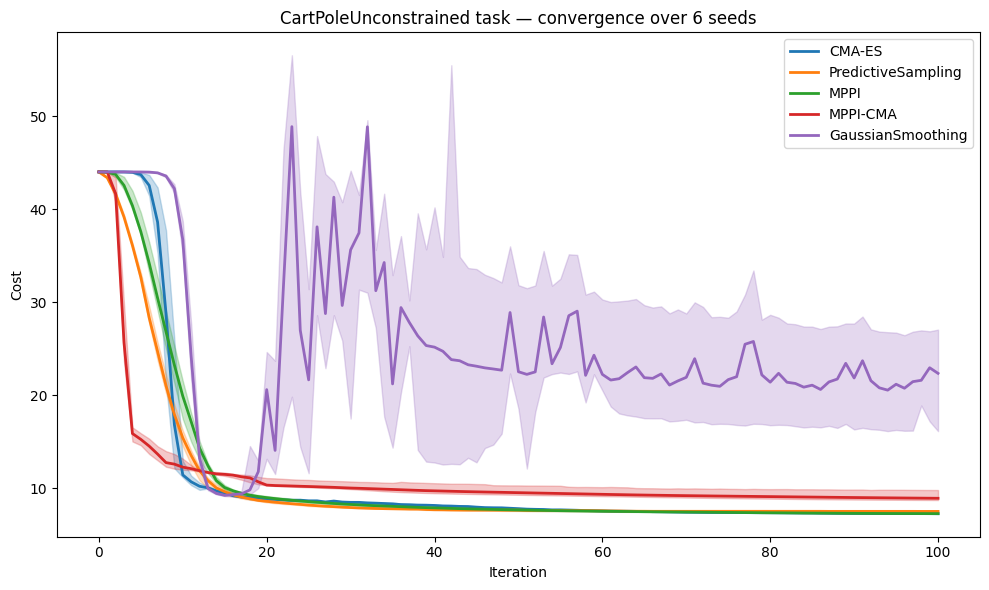

In [ ]:
import matplotlib.pyplot as plt

methods = {
    "CMA-ES"           : CMAES_costs,
    "PredictiveSampling": PS_costs,
    "MPPI"             : MPPI_costs,
    "MPPI-CMA"         : MPPI_CMA_costs,
    "GaussianSmoothing": GS_costs,
}

# ------------------------------------------------------------------
# 1)  Compute summaries and plot
# ------------------------------------------------------------------
iters   = np.arange(next(iter(methods.values())).shape[1])   # x-axis
colors  = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default color cycle

plt.figure(figsize=(10, 6))

for (name, costs), color in zip(methods.items(), colors):
    q25    = np.quantile(costs, 0.25, axis=0)
    median = np.quantile(costs, 0.50, axis=0)
    q75    = np.quantile(costs, 0.75, axis=0)
    
    plt.plot(iters, median, lw=2, label=name, color=color)
    plt.fill_between(iters, q25, q75, alpha=0.25, color=color)

# ------------------------------------------------------------------
# 2)  Cosmetics
# ------------------------------------------------------------------
task_name = task.__class__.__name__
plt.title(f"{task_name} task — over {num_trails} seeds")
plt.xlabel("Iteration")
plt.ylabel("Cost")
# plt.yscale("log")      # uncomment if the range is huge
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3)  Optional rollout visualisation
# ------------------------------------------------------------------
to.visualize_rollout(task, controller=ctrl)

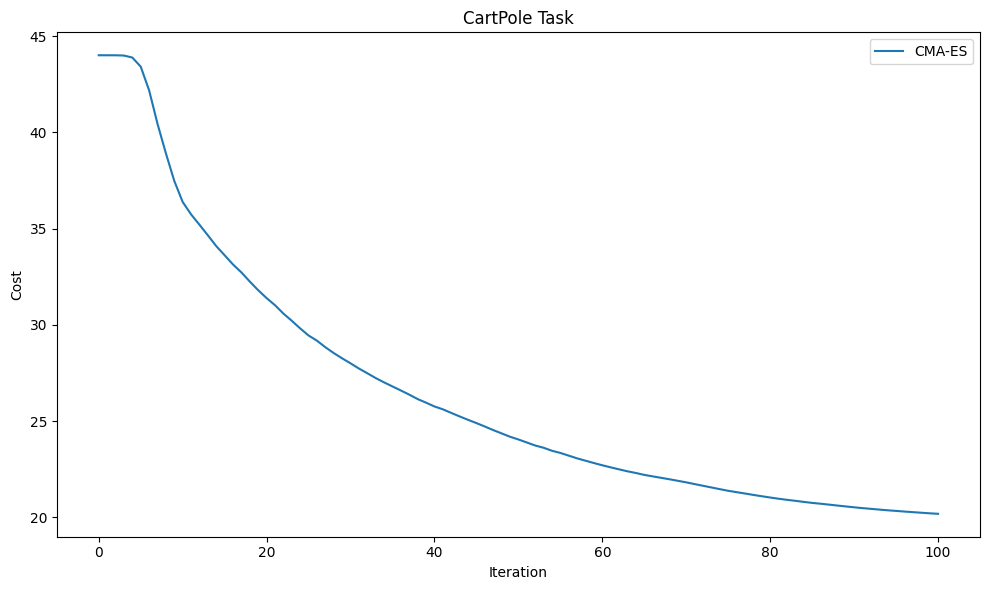

In [ ]:
import matplotlib.pyplot as plt

task_name = task.__class__.__name__
# print(xNES_costs)
# # Plot the costs
plt.figure(figsize=(10, 6))

CMAES_costs = np.array(CMAES_costs).T

plt.plot(CMAES_costs,  label="CMA-ES")


plt.title( task_name + " Task")
plt.xlabel("Iteration")
plt.ylabel("Cost")

# single legend call:
plt.legend(loc="best")
plt.tight_layout()
plt.show()
to.visualize_rollout(task, controller=ctrl)
